# Regression Coefficients Nullspace Perspective
This notebook contains contains examples and visualizations of the nullspace perspective for regression in high dimensions on LFP Data.
Corresponding paper: 

The LFP Data was originally published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
import sys
import os

abspath = r"./src/"
sys.path.append(os.path.abspath(abspath ))

import numpy as np 
import pandas as pd
import scipy 

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import matplotlib.transforms as mtransforms

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42)

# Custom functions
from hd_data import HD_Data
from basis_function_data import construct_y_data
from nullspace import Nullspace

from utils import optimize_pls_cv, predict_LFP_based_on_coef, rmse
from plotting_utils import vis_reg_coef, plot_x_tt2, set_axis_label

%load_ext autoreload
%autoreload 2
plt.style.use('./src/plots.mplstyle')

In [2]:
# Varibles to set. 
# Paths are OS dependent.

# Data path
data_path = './data/'
# Shall plots be saved?
save_plots = True

# Path to save plots
save_plot_path = './results/Nullspace/'

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False

In [3]:
# Create PLS Model objects. 

# Extend this list up to 20 components using a for loop 
models = []
model_names = []
for i in range(1, 21):
    models.append(PLSRegression(n_components=i, tol=1e-7, scale=False))
    model_names.append('PLS ' + str(i) + ' Comp.')


In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv(data_path + 'lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_cl = np.array(lfp_df.iloc[:, 1000])
d_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_cl_train = np.array(y_cl[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_cl_test = np.array(y_cl[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_cl_test2 = np.array(y_cl[lfp_df.iloc[:, 1002]==2])

# Remove outliers in the test set. 
# Reason: Very different shape and a lot lower cycle life than all other cells. 
# Degradation is not linear. 
id_outlier_test = np.where(np.mean(X_lfp_test, axis=1)==np.min(np.mean(X_lfp_test, axis=1)))
X_lfp_test = np.delete(X_lfp_test, id_outlier_test, axis=0)
y_cl_test = np.delete(y_cl_test, id_outlier_test, axis=0)

stdx = np.std(X_lfp_train, axis=0, ddof=1)
meanx = np.mean(X_lfp_train, axis=0)
X_ = X_lfp_train - meanx
X_lfp_train_std = X_ / stdx

X_test1_ = X_lfp_test - meanx
X_test1_std = X_test1_ / stdx
X_test2_ = X_lfp_test2 - meanx
X_test2_std = X_test2_ / stdx

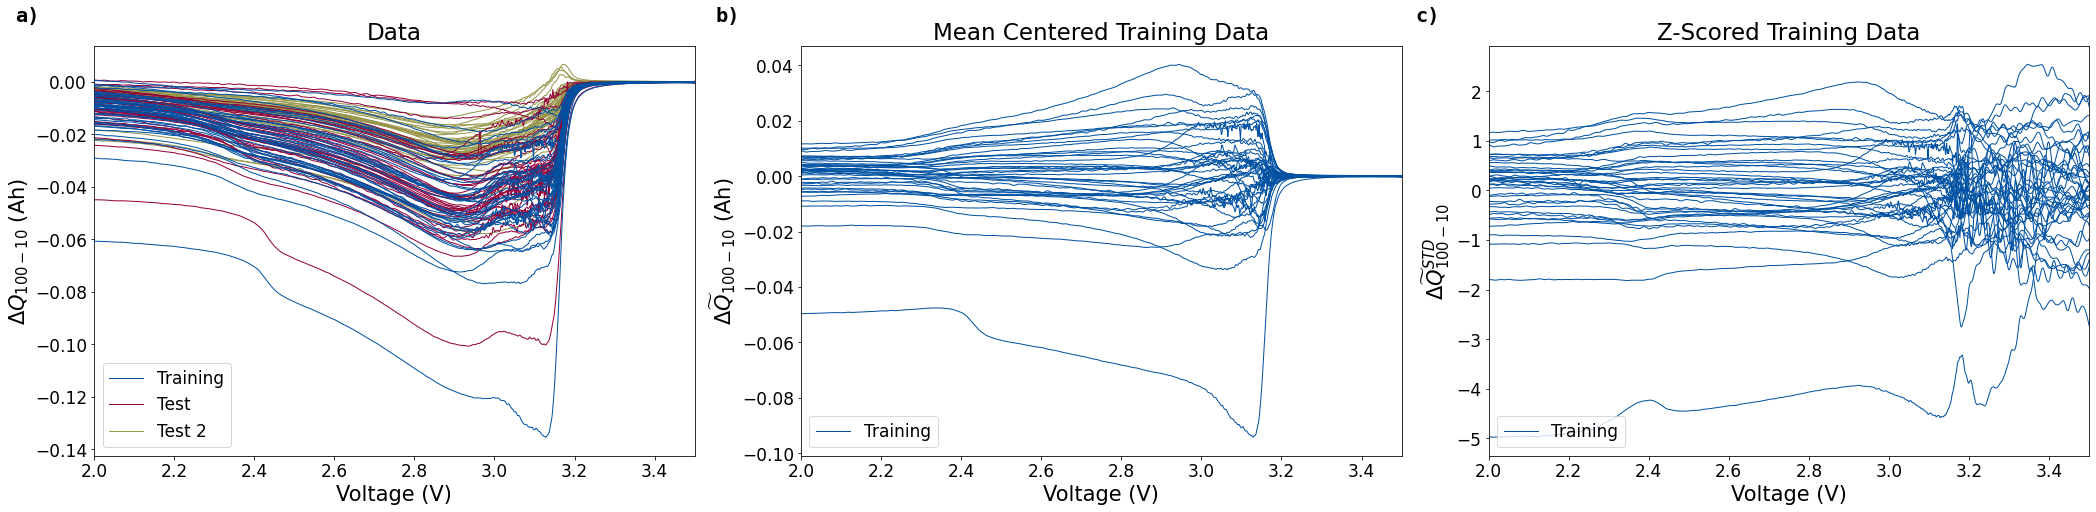

In [5]:
figsize = [29, 7]
fig, ax = plt.subplots(1, 3, figsize=figsize, constrained_layout=True, sharex=True)
x_label = 'Voltage (V)'
y_label = r'$\Delta Q_{100-10}$ (Ah)'
y_label_ = r'$\Delta \widetilde{Q}_{100-10}$ (Ah)'
y_label_std_ = r'$\Delta \widetilde{Q}_{100-10}^{STD}$'
# IBM and other colors!
colors_IBM_ao = ["#0051a2", "#97964a", "#f4777f", "#93003a", "#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000"]
ax[0] = plot_x_tt2(X_lfp_train, d_lfp, ax[0], colors_IBM_ao[0], x_label, y_label, zorder=3)
ax[0] = plot_x_tt2(X_lfp_test, d_lfp, ax[0], colors_IBM_ao[3],  x_label, y_label, label_data='Test', zorder=2)
ax[0] = plot_x_tt2(X_lfp_test2, d_lfp, ax[0], colors_IBM_ao[1], x_label, y_label, label_data='Test 2', zorder=1)
ax[0].set_title('Data')
ax[0].set_xlim(2.0, 3.5)


ax[1] = plot_x_tt2(X_lfp_train-np.mean(X_lfp_train, axis=0), d_lfp, ax[1], colors_IBM_ao[0], x_label, y_label_, label_data='Training')
ax[1].set_title('Mean Centered Training Data')
ax[1].set_xlim(2.0, 3.5)

ax[2] = plot_x_tt2(X_lfp_train_std, d_lfp, ax[2], colors_IBM_ao[0], x_label, y_label_std_, label_data='Training')
ax[2].set_title('Z-Scored Training Data')
ax[2].set_xlim(2.0, 3.5)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.04, 1.0))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.05, 1.0))
fig, ax[2] = set_axis_label(fig, ax[2], trans, label_str="c)", loc=(-0.03, 1.0))

if save_plots:
    plt.savefig(save_plot_path + 'data_lfp.pdf')
plt.show()

# fig, ax = plot_X(X_lfp_train, d_lfp)
# if save_plots: 
#    fig.savefig(save_plot_path + 'TrainingData.pdf') 

/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

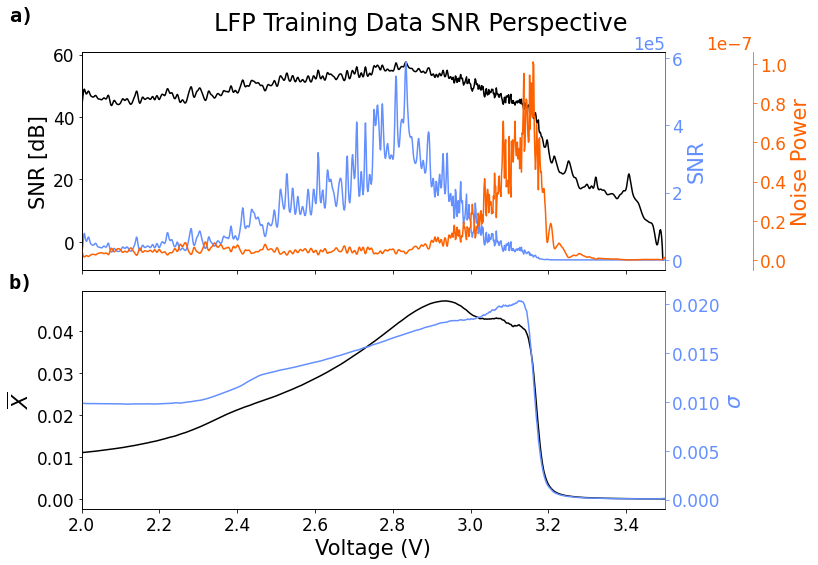

In [6]:
lfp_train_hdata = HD_Data(X_lfp_train, d_lfp, y=[])
fig, ax = lfp_train_hdata.analyze_snr_by_splines(s=1e-5, k=3, mode="X_raw", x_label='Voltage (V)')
# Add axis labels 

# Put a title above the figure
fig.suptitle('LFP Training Data SNR Perspective')
# put figure title higher
fig.subplots_adjust(top=0.91)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.03, 1.03))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.03, 0.9))

if save_plots:
    plt.savefig(save_plot_path + 'SNR_TrainingData.pdf')
# Noise is heteroscedastic, violates the usual assumption!

/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/hd_data.py:229: RuntimeWarning: invalid value encountered in log10
  self.snr_smooth_dB = savgol_filter(10 * np.log10(snr), window_length, polyorder)


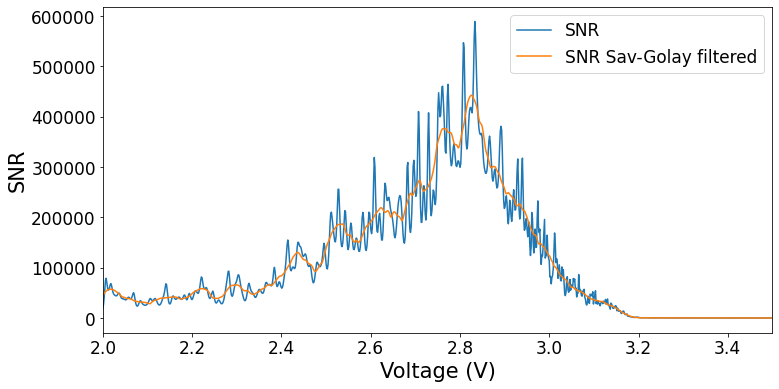

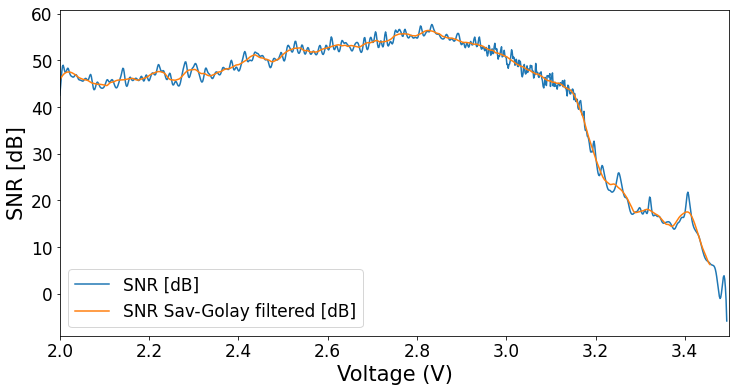

In [7]:

lfp_train_hdata.smooth_snr(window_length=51, polyorder=3)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr, label="SNR")
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr_smooth, label="SNR Sav-Golay filtered")
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('SNR')
ax.set_xlim(2.0, 3.5)
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr_dB, label="SNR [dB]")
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr_smooth_dB, label="SNR Sav-Golay filtered [dB]")
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('SNR [dB]')
ax.set_xlim(2.0, 3.5)
ax.legend()
plt.show()

# Save the snr_smooth_dB to csv (it is a numpy array)
np.savetxt("data/lfp_snr_smooth_dB.csv", lfp_train_hdata.snr_smooth_dB, delimiter=",")
np.savetxt("data/lfp_snr_smooth.csv", lfp_train_hdata.snr_smooth, delimiter=",")

In [8]:
y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_data: 
    y_lfp_train_mean_function = construct_y_data(X_lfp_train, mean_function, per_range=[0,1])
    data_lfp_mean = HD_Data(X=X_lfp_train, d=d_lfp, y=y_lfp_train_mean_function)
    data_lfp_mean = data_lfp_mean.add_wgn(snr_y=50)

    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_mean.csv', data_lfp_mean.y, delimiter=",", 
            header='Sample Mean reposne for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_mean.csv', skiprows=1, delimiter=',')
    data_lfp_mean = HD_Data(X=X_lfp_train, d=d_lfp, y=y)

## LFP dataset synthethic y

In [9]:
nulls_lfp_mean = Nullspace(data_lfp_mean)
nulls_lfp_mean = nulls_lfp_mean.learn_weights(models, model_names)
nulls_lfp_mean.set_standardization(std=False)

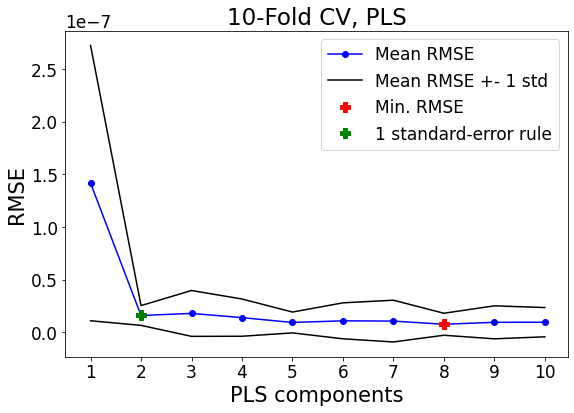

{'rmse_vals': array([1.41710341e-07, 1.60044265e-08, 1.79537966e-08, 1.39695960e-08,
        9.37500391e-09, 1.09340506e-08, 1.06839772e-08, 7.68231938e-09,
        9.50886078e-09, 9.63944282e-09]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 1,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [10]:
optimize_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=False)

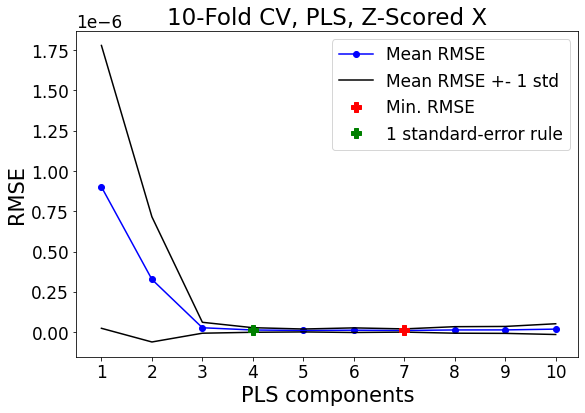

{'rmse_vals': array([9.01133511e-07, 3.27362171e-07, 2.74400638e-08, 1.35669929e-08,
        1.05880301e-08, 1.23376486e-08, 1.04275365e-08, 1.38797029e-08,
        1.40837453e-08, 1.89388895e-08]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 3,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [11]:
optimize_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=True)

Constraint value: 0.010000100022, Method NRMSE


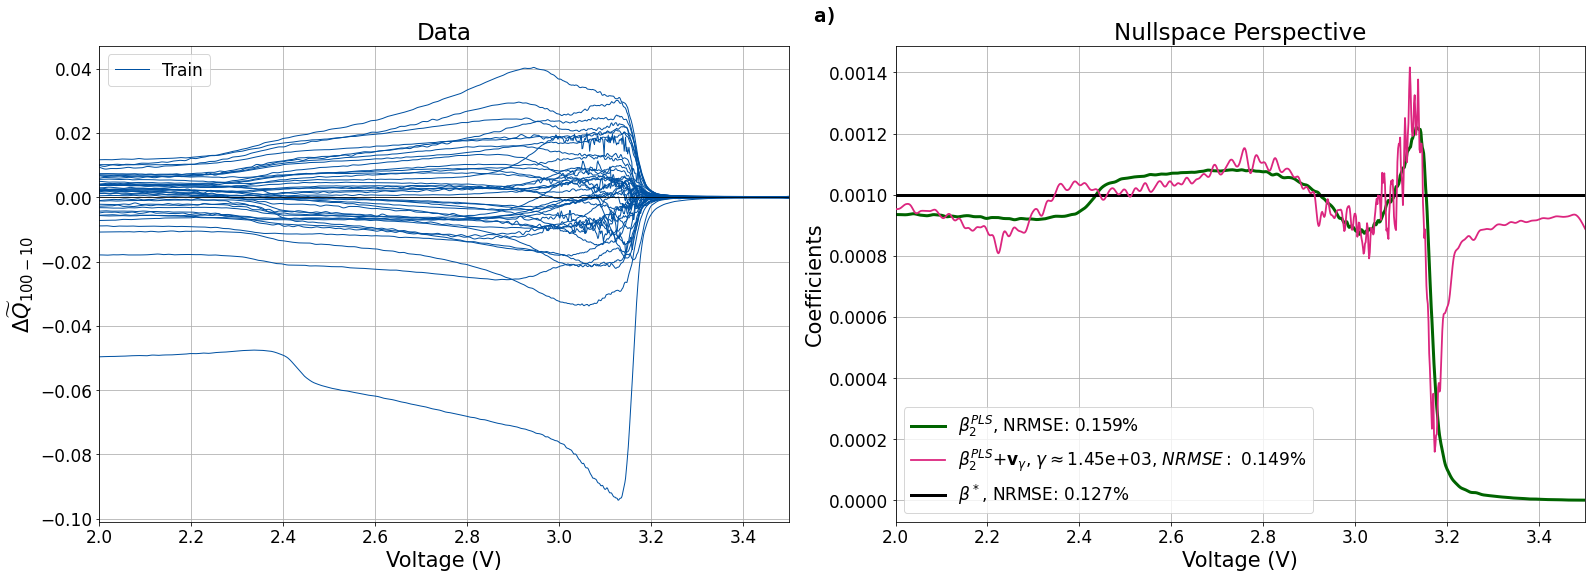

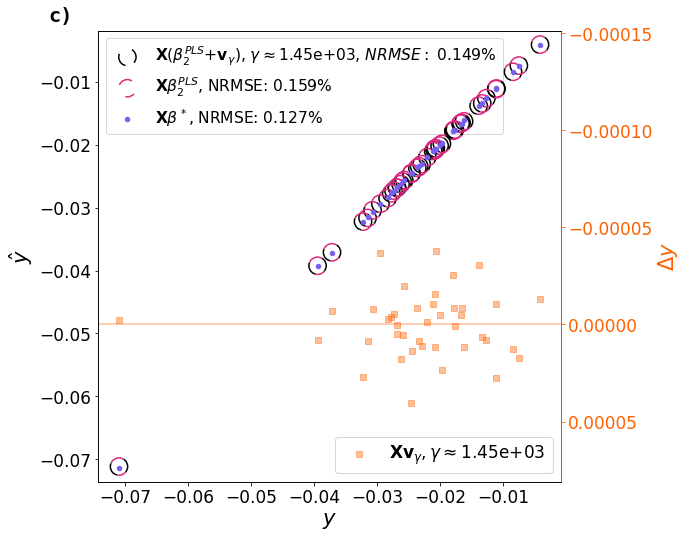

In [12]:
nulls_lfp_mean.set_standardization(std=False)
nulls_lfp_mean.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name=r'$\beta_{2}^{PLS}$',
    w_beta = mean_reg_coef_lfp, 
    w_beta_name=r'$\beta^*$'
    )

nulls_lfp_mean, fig, ax = nulls_lfp_mean.nullspace_analysis(
    plot_results=True, 
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.01,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    )


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_2PLS_mean.pdf')

nulls_lfp_mean.scatter_predictions()

Constraint value: 0.010000099982, Method NRMSE


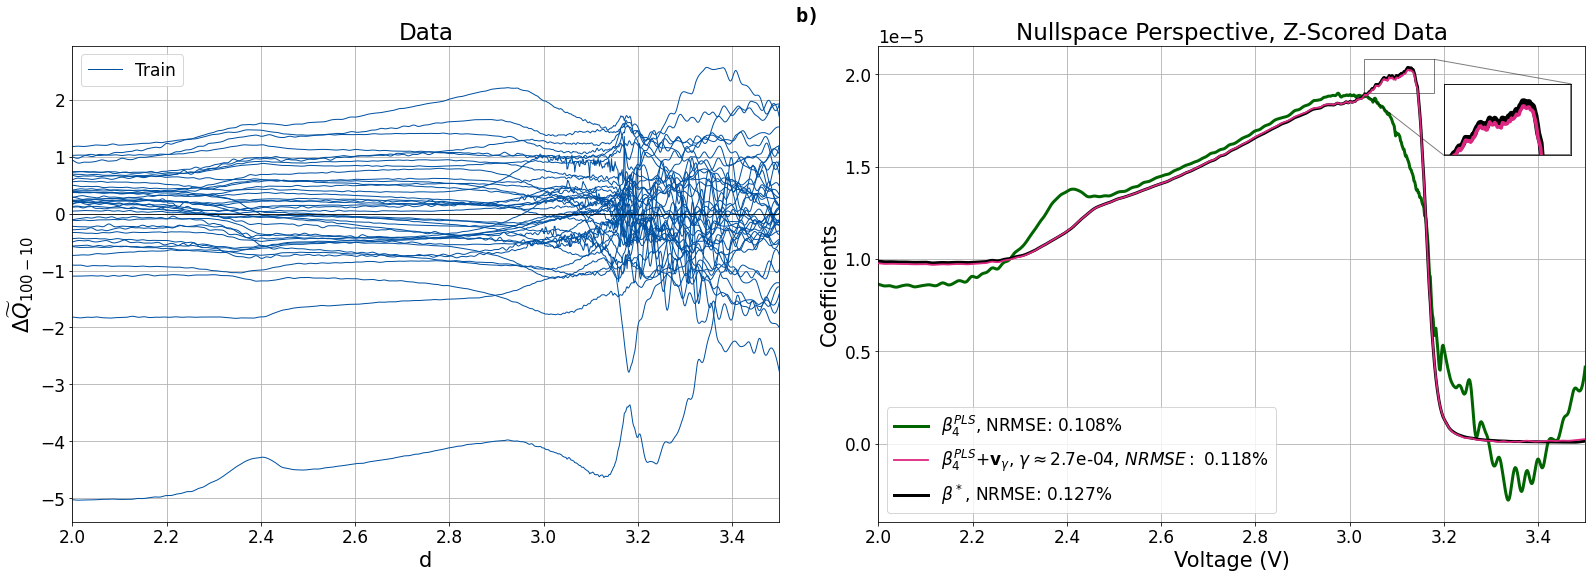

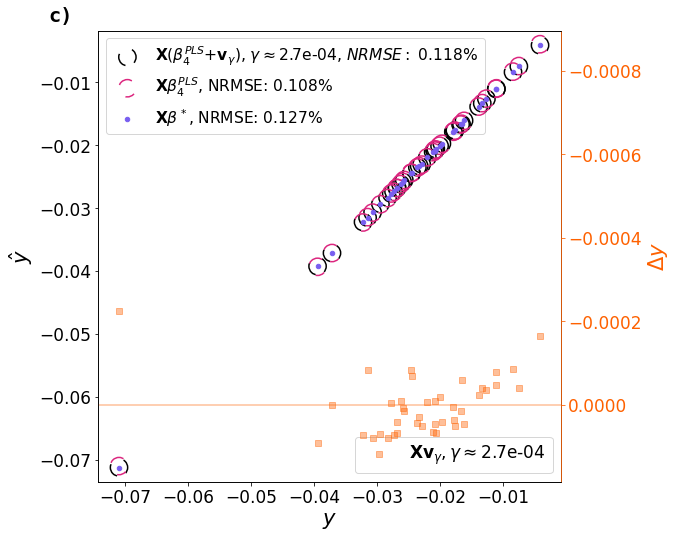

In [13]:
nulls_lfp_mean.set_standardization(std=True)

nulls_lfp_mean.set_nullspace_weights(
    key_alpha = 'PLS 4 Comp.', 
    w_alpha_name=r'$\beta_{4}^{PLS}$',
    w_beta = mean_reg_coef_lfp, 
    w_beta_name=r'$\beta^*$',
    )

nulls_lfp_mean, fig, ax = nulls_lfp_mean.nullspace_analysis(
    plot_results=True,
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.01,
    nullspace_path = False,
    ax_labelstr = ("", "b)"),
    inset_axes_ce = [0.8, 0.77, 0.18, 0.15],
    zoom_coords = [3.03, 3.18, 1e-5*1.9, 1e-5*2.08],
    )

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')   
ax[1].set_title('Nullspace Perspective, Z-Scored Data')
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_4PLS_mean.pdf')


nulls_lfp_mean.scatter_predictions()

## Colum mean weights

In [14]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column_mean 

rcoef_lfp_cm =  np.mean(X_lfp_train, axis=0)

if not load_data: 
    y_lfps_train_cm = np.dot(X_lfp_train, rcoef_lfp_cm)

    dml_lfps_cm = HD_Data(X=X_lfp_train, d=d_lfp, y=y_lfps_train_cm)
    # Add noise to target values
    dml_lfps_cm = dml_lfps_cm.add_wgn(snr_y=50)
    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_cm.csv', dml_lfps_cm.y, delimiter=',', 
            header='Column Mean response for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_cm.csv', skiprows=1, delimiter=',')
    dml_lfps_cm = HD_Data(X=X_lfp_train, d=d_lfp, y=y)

nulls_lfp_cm = Nullspace(dml_lfps_cm)
nulls_lfp_cm = nulls_lfp_cm.learn_weights(models, model_names)

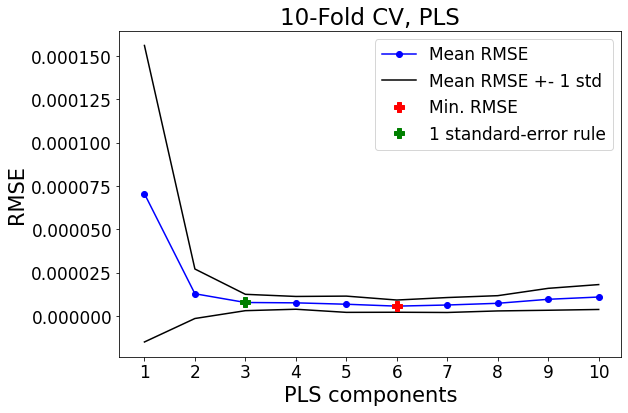

{'rmse_vals': array([7.06231051e-05, 1.29164070e-05, 7.87486197e-06, 7.67211286e-06,
        6.86982697e-06, 5.77386524e-06, 6.42430136e-06, 7.40929881e-06,
        9.72125591e-06, 1.10281926e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 2,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [15]:
optimize_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=False)

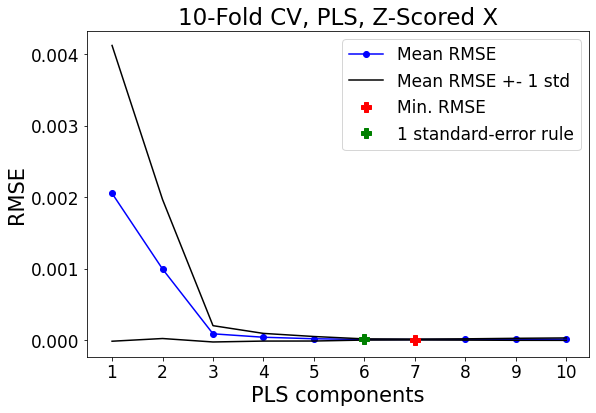

{'rmse_vals': array([2.05462372e-03, 9.97192183e-04, 9.12253853e-05, 4.34543504e-05,
        2.21728222e-05, 1.22813258e-05, 1.16580890e-05, 1.23505581e-05,
        1.44912669e-05, 1.68009043e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 5,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [16]:
optimize_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=True)

Constraint value: 0.005000100000, Method NRMSE


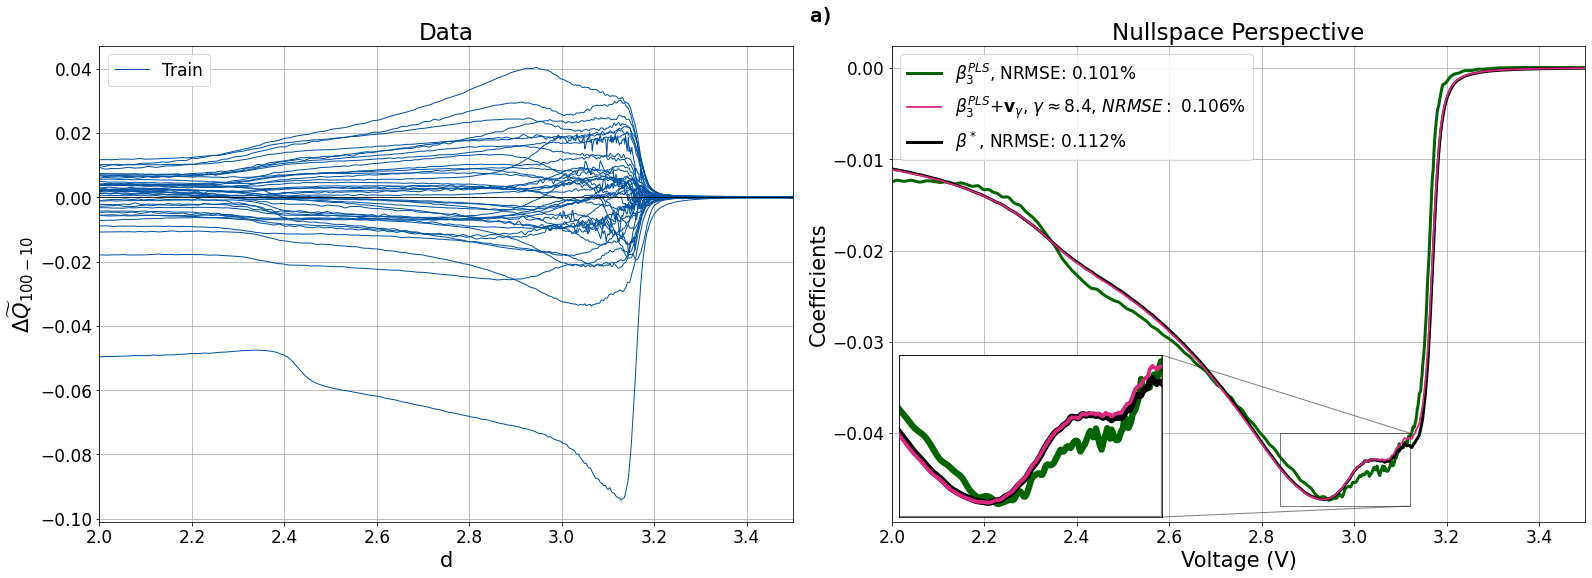

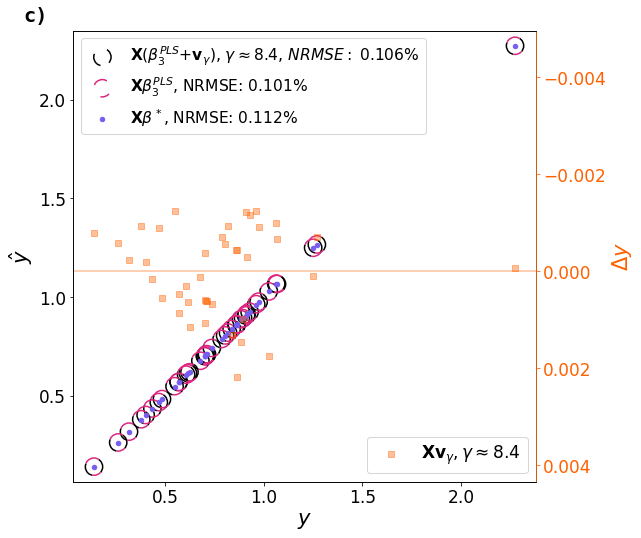

In [17]:
nulls_lfp_cm.set_standardization(std=False)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 3 Comp.', 
    w_alpha_name=r'$\beta_{3}^{PLS}$',
    w_beta = rcoef_lfp_cm, 
    w_beta_name=r'$\beta^*$',
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True,
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.005,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    inset_axes_ce = [0.01, 0.01, 0.38, 0.34],
    zoom_coords = [2.84, 3.12, -0.048, -0.04],
    )
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_3PLS_cm.pdf')


nulls_lfp_cm.scatter_predictions()

Constraint value: 0.005000099998, Method NRMSE


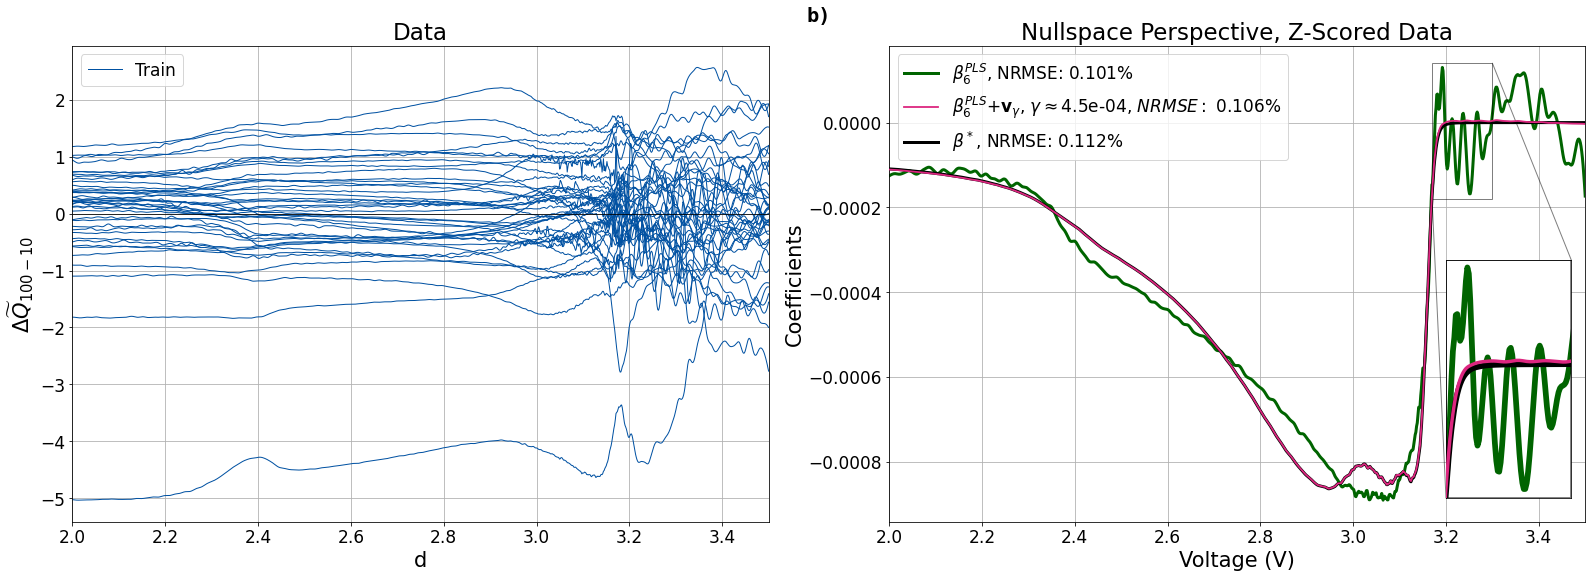

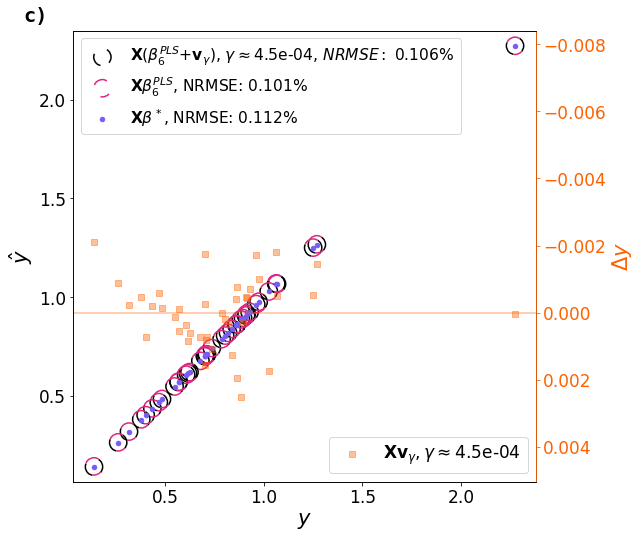

In [18]:
nulls_lfp_cm.set_standardization(std=True)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 6 Comp.', 
    w_alpha_name=r'$\beta_{6}^{PLS}$',
    w_beta = rcoef_lfp_cm, 
    w_beta_name=r'$\beta^*$',
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True,
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.005,
    nullspace_path = False,
    ax_labelstr = ("", "b)"),
    inset_axes_ce = [0.8, 0.05, 0.18, 0.5],
    zoom_coords = [3.17, 3.3, -0.00018, 0.00014],
    )
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].set_title('Nullspace Perspective, Z-Scored Data')

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_6PLS_cm_std.pdf')


nulls_lfp_cm.scatter_predictions()

## Cycle Life Response

In [19]:
# Check the results
X_train_var = np.log10(np.var(X_lfp_train, axis=1, ddof=1)).copy()
mean_x = np.mean(X_train_var)
X_train_var_ = X_train_var - mean_x
X_test1_var = np.log10(np.var(X_lfp_test, axis=1, ddof=1)).copy()
X_test1_var_ = X_test1_var - mean_x
X_test2_var = np.log10(np.var(X_lfp_test2, axis=1, ddof=1)).copy()
X_test2_var_ = X_test2_var - mean_x

y_cl_train_ = np.log10(y_cl_train).copy()
mean_y_train = np.mean(y_cl_train_)
y_cl_train_ -= mean_y_train
y_cl_test_ = np.log10(y_cl_test).copy() -  mean_y_train
y_cl_test2_ = np.log10(y_cl_test2).copy() -   mean_y_train

# Ordinary Least Squares Regression 
beta = (1/(X_train_var_.T @ X_train_var_)) * X_train_var_.T @ y_cl_train_
# Reshape beta to a 2D array
beta = np.reshape(beta, (1, -1))
# Predict the cycle life of the set
pred_train = 10**(X_train_var_.reshape(-1, 1)@beta + mean_y_train).reshape(-1)
pred_test  = 10**(X_test1_var_.reshape(-1, 1)@beta + mean_y_train).reshape(-1)
pred_test2 = 10**(X_test2_var_.reshape(-1, 1)@beta + mean_y_train).reshape(-1)

# Print RMSE
print('RMSE Train: ', np.sqrt(np.mean((pred_train - y_cl_train)**2)))
print('RMSE Test: ',  np.sqrt(np.mean((pred_test - y_cl_test)**2)))
print('RMSE Test2: ', np.sqrt(np.mean((pred_test2 - y_cl_test2)**2)))

RMSE Train:  103.57188283462595
RMSE Test:  138.29827606240377
RMSE Test2:  195.86416882282867


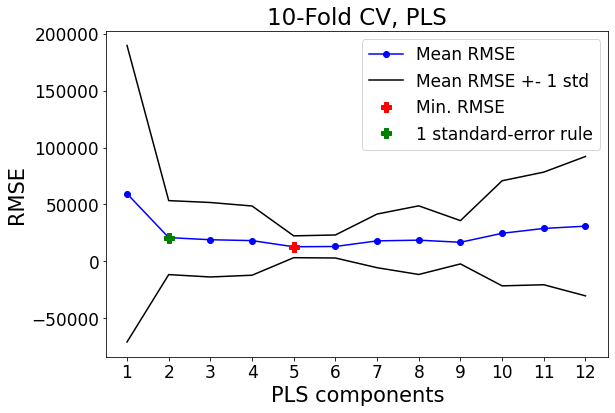

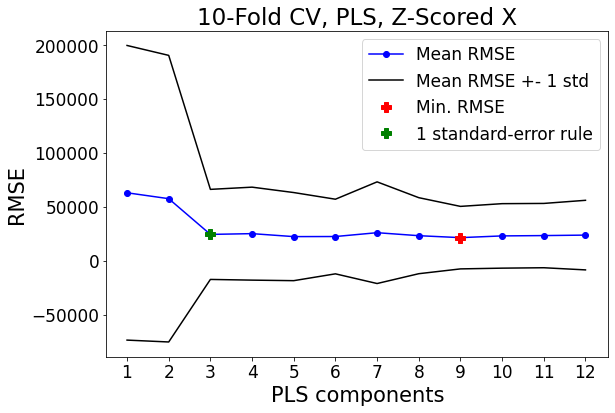

In [20]:
# Set random seed for reproducibility
random.seed(40)
np.random.seed(40)

y_log_cl = np.log(y_cl_train).copy()
y_cl = y_cl_train
y_log_cl_ = y_log_cl - np.mean(y_log_cl)


# Optimize the number of components for the PLS model based on standardized data and not standardized data.
# cv_dict = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=False, neg_rmse_exp_scorer=False)
# cv_dict_pls_std = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=True, neg_rmse_exp_scorer=False)

# Estimate the generalization error on the original scale of the response variable.
cv_dict = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=False, neg_rmse_exp_scorer=True)
cv_dict_pls_std = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=True, neg_rmse_exp_scorer=True)



In [21]:
dml_lfps_cl = HD_Data(X=X_lfp_train, d=d_lfp, y=y_log_cl)
nulls_lfp_cl = Nullspace(dml_lfps_cl)
nulls_lfp_cl.set_standardization(std=False)
nulls_lfp_cl = nulls_lfp_cl.learn_weights(models, model_names)
# nulls_lfp_cl.set_standardization(std=True)
# nulls_lfp_cl = nulls_lfp_cl.learn_weights(models, model_names)

In [22]:
# Load file 
file_name = "regression_in_R/lfp_cl_D1_cv_reg_coeff.csv"
reg_coef_d1 = pd.read_csv(file_name, index_col=0)

file_name = "regression_in_R/lfp_cl_D2_cv_reg_coeff.csv"
reg_coef_d2 = pd.read_csv(file_name, index_col=0)

file_name = "regression_in_R/lfp_cl_D1_std_cv_reg_coeff.csv"
reg_coef_d1_std = pd.read_csv(file_name, index_col=0)

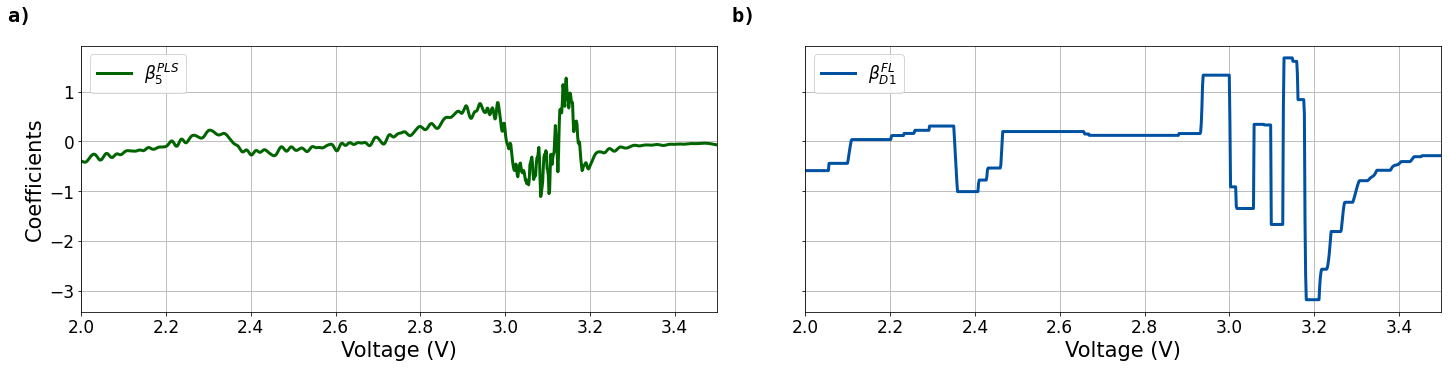

In [23]:
figsize = [20, 5]
fig, ax = plt.subplots(1, 2, figsize=figsize, constrained_layout=True, sharex=True, sharey=True)

nb_comp = 5
fig, ax[0] = vis_reg_coef(
    beta = nulls_lfp_cl.weights[f'PLS {nb_comp} Comp.'],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{5}^{PLS}$",
    fig = fig, 
    ax = ax[0],
    cid=0)

fig, ax[1] = vis_reg_coef(
    beta = reg_coef_d1.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$",
    fig = fig, 
    ax = ax[1],
    cid=1)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.03, 1.0))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.03, 1.0))

ax[0].set_xlabel("Voltage (V)")
ax[1].set_xlabel("Voltage (V)")
ax[0].set_ylabel("Coefficients")

#fig.suptitle("Cross-Validate Generalized Lasso Regression Coefficients")

# Save figure
if save_plots:
    plt.savefig(save_plot_path + 'LFP_CL_CV_Reg_Coeff_genlasso_s.pdf')

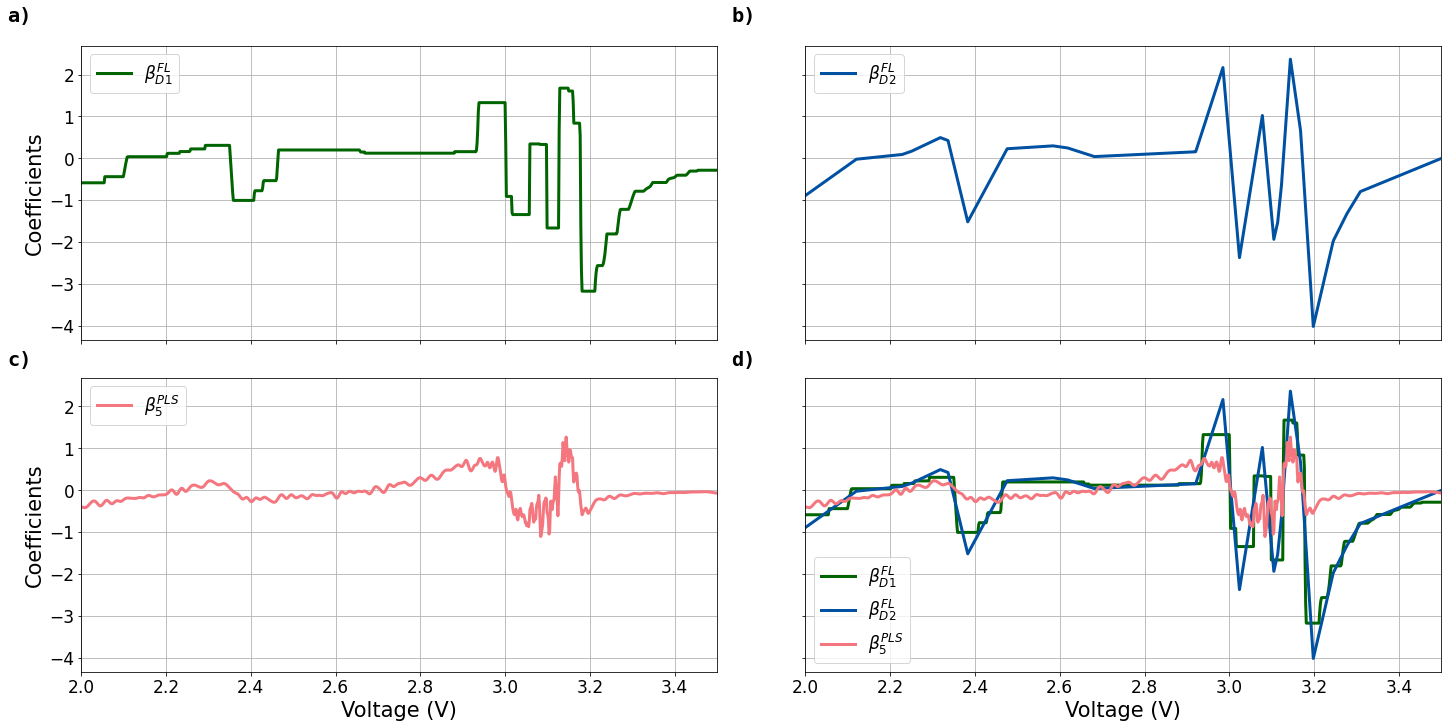

In [24]:
if 1:
    figsize = [20, 10]
    fig, ax = plt.subplots(2, 2, figsize=figsize, constrained_layout=True, sharex=True, sharey=True)

    fig, ax[0, 0] = vis_reg_coef(
        beta = reg_coef_d1.iloc[:, 1],
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{D1}^{FL}$",
        fig = fig, 
        ax = ax[0, 0],
        cid=0)

    fig, ax[0, 1] = vis_reg_coef(
        beta = reg_coef_d2.iloc[:, 1],
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{D2}^{FL}$",
        fig = fig, 
        ax = ax[0, 1],
        cid=1)

    nb_comp = 5
    fig, ax[1, 0] = vis_reg_coef(
        beta = nulls_lfp_cl.weights[f'PLS {nb_comp} Comp.'],
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{5}^{PLS}$",
        fig = fig, 
        ax = ax[1, 0],
        cid=3)

    fig, ax[1, 1] = vis_reg_coef(
        beta = reg_coef_d1.iloc[:, 1],
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{D1}^{FL}$",
        fig = fig, 
        ax = ax[1, 1],
        cid=0)

    fig, ax[1, 1] = vis_reg_coef(
        beta = reg_coef_d2.iloc[:, 1],
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{D2}^{FL}$",
        fig = fig, 
        ax = ax[1, 1],
        cid=1)

    fig, ax[1, 1] = vis_reg_coef(
        beta = nulls_lfp_cl.weights[f'PLS {nb_comp} Comp.'],
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{5}^{PLS}$",
        fig = fig, 
        ax = ax[1, 1],
        cid=3)


    trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
    fig, ax[0,0] = set_axis_label(fig, ax[0,0], trans, label_str="a)", loc=(-0.03, 1.0))
    fig, ax[0,1] = set_axis_label(fig, ax[0,1], trans, label_str="b)", loc=(-0.03, 1.0))
    fig, ax[1,0] = set_axis_label(fig, ax[1,0], trans, label_str="c)", loc=(-0.03, 0.96))
    fig, ax[1,1] = set_axis_label(fig, ax[1,1], trans, label_str="d)", loc=(-0.03, 0.96))

    ax[1,0].set_xlabel("Voltage (V)")
    ax[1,1].set_xlabel("Voltage (V)")
    ax[0,0].set_ylabel("Coefficients")
    ax[1,0].set_ylabel("Coefficients")
    ax[1,1].legend(loc=3)
    #fig.suptitle("Cross-Validate Generalized Lasso Regression Coefficients")

    # Save figure
    if save_plots:
        plt.savefig(save_plot_path + 'LFP_CL_CV_Reg_Coeff_genlasso.pdf')

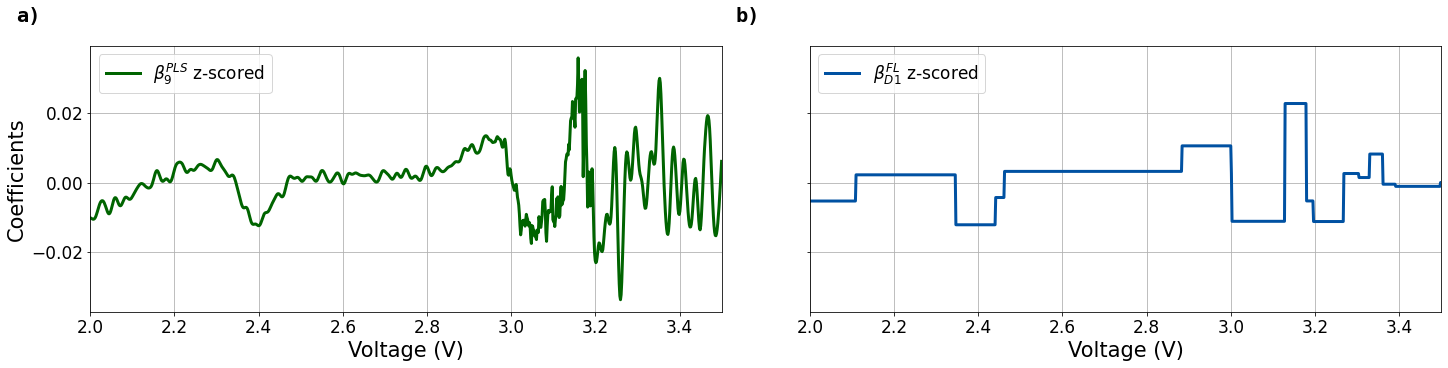

In [25]:
plot_rescaled_regression_coefficients = False

if plot_rescaled_regression_coefficients:
    figsize = [20, 10]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    ax11 = plt.subplot(gs[1, 1])
    ax10 = plt.subplot(gs[1, 0])
    ax00 = plt.subplot(gs[0, 0])
    ax01 = plt.subplot(gs[0, 1], sharey=ax00)
else:
    figsize = [20, 5]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(1, 2)
    ax00 = plt.subplot(gs[0, 0])
    ax01 = plt.subplot(gs[0, 1], sharey=ax00)

    # fig, ax = plt.subplots(2, 2, figsize=figsize, constrained_layout=True, sharex=True, sharey='row')

fig, ax00 = vis_reg_coef(
    beta = nulls_lfp_cl.weights['PLS 9 Comp. std'],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{9}^{PLS}$ z-scored",
    fig = fig, 
    ax = ax00,
    cid=0)

fig, ax01 = vis_reg_coef(
    beta = reg_coef_d1_std.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$ z-scored",
    fig = fig, 
    ax = ax01,
    cid=1)
plt.setp(ax01.get_yticklabels(), visible=False)
ax00.set_ylabel("Coefficients")  # \n z-scored columns")
trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax00 = set_axis_label(fig, ax00, trans, label_str="a)", loc=(-0.03, 1.0))
fig, ax01 = set_axis_label(fig, ax01, trans, label_str="b)", loc=(-0.03, 1.0))
if plot_rescaled_regression_coefficients:
    ax00.set_xticklabels([])
    ax01.set_xticklabels([])

    fig, ax10 = vis_reg_coef(
        beta = nulls_lfp_cl.weights['PLS 9 Comp. std']/np.std(X_, axis=0),
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{9}^{PLS}$ z-scored rescaled",
        fig = fig, 
        ax = ax10,
        cid=0)

    #ax[1, 1].get_shared_x_axes().remove(ax[1, 0])
    fig, ax11 = vis_reg_coef(
        beta = reg_coef_d1_std.iloc[:, 1]/np.std(X_, axis=0),
        d = np.linspace(2.0, 3.5, 1000),
        y = y_log_cl,
        label = r"$\beta_{D1}^{FL} z-scored rescaled$",
        fig = fig, 
        ax = ax11,
        cid=1)

    trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
    fig, ax10 = set_axis_label(fig, ax10, trans, label_str="c)", loc=(-0.03, 1.0))
    fig, ax11 = set_axis_label(fig, ax11, trans, label_str="d)", loc=(-0.03, 1.0))

    ax10.set_xlabel("Voltage (V)")
    ax11.set_xlabel("Voltage (V)")
    ax10.set_ylabel("Coefficients \n original scale columns")
    #fig.suptitle("Cross-Validate Generalized Lasso Regression Coefficients")
    if save_plots:
        plt.savefig(save_plot_path + 'LFP_CL_CV_Reg_Coeff_PLS_genlasso_std.pdf')
else:
    ax00.set_xlabel("Voltage (V)")
    ax01.set_xlabel("Voltage (V)")
    if save_plots:
        plt.savefig(save_plot_path + 'LFP_CL_CV_Reg_Coeff_PLS_genlasso_std_s.pdf')



In [26]:
# Run the variance model on the LFP data

log_var_train = np.log(np.var(X_lfp_train, axis=1))
mean_log_var_train = np.mean(log_var_train)
log_var_train_ = log_var_train-mean_log_var_train
log_var_test1 = np.log(np.var(X_lfp_test, axis=1))   
log_var_test1_ = log_var_test1-mean_log_var_train
log_var_test2 = np.log(np.var(X_lfp_test2, axis=1))
log_var_test2_ = log_var_test2-mean_log_var_train

log_y_cl_train_mean = np.mean(np.log(y_cl_train))
log_y_cl_train_ = np.log(y_cl_train)-log_y_cl_train_mean

# Fit the model
w = np.linalg.lstsq(log_var_train_.reshape(-1, 1), log_y_cl_train_, rcond=None)[0]

In [27]:
df_rmse = pd.DataFrame()
split_eval_cycle = 1200
print("D1")
df_rmse = predict_LFP_based_on_coef(
    X_, X_test1_, X_test2_, y_cl_train, y_cl_test, y_cl_test2, reg_coef_d1.iloc[:, 1], np.mean(y_log_cl), df_rmse, 'D1', split_eval_cycle=split_eval_cycle)
# print("D2")
# df_rmse = predict_LFP_based_on_coef(
#     X_, X_test1_, X_test2_, y_cl_train, y_cl_test, y_cl_test2, reg_coef_d2.iloc[:, 1], np.mean(y_log_cl), df_rmse, 'D2')
print("PLS 5 Comp.")
df_rmse = predict_LFP_based_on_coef(
    X_, X_test1_, X_test2_, y_cl_train, y_cl_test, y_cl_test2, nulls_lfp_cl.weights['PLS 5 Comp.'], np.mean(y_log_cl), df_rmse, 'PLS 5 Comp.', split_eval_cycle=split_eval_cycle)
print("D1 Z-Scored")
df_rmse = predict_LFP_based_on_coef(
    X_lfp_train_std, X_test1_std, X_test2_std, y_cl_train, y_cl_test, y_cl_test2, reg_coef_d1_std.iloc[:, 1], np.mean(y_log_cl), df_rmse, 'D1 Z-Scored', split_eval_cycle=split_eval_cycle)
print("PLS 9 Comp. Z-Scored")
df_rmse = predict_LFP_based_on_coef(
    X_lfp_train_std, X_test1_std, X_test2_std, y_cl_train, y_cl_test, y_cl_test2, nulls_lfp_cl.weights['PLS 9 Comp. std'], np.mean(y_log_cl), df_rmse, 'PLS 9 Comp. Z-Scored', split_eval_cycle=split_eval_cycle)

df_rmse = predict_LFP_based_on_coef(
    log_var_train_.reshape(-1, 1), 
    log_var_test1_.reshape(-1, 1), 
    log_var_test2_.reshape(-1, 1), 
    y_cl_train, 
    y_cl_test, 
    y_cl_test2, 
    w, 
    np.mean(np.log(y_cl_train)), 
    df_rmse, 
    "Variance Model", 
    split_eval_cycle=split_eval_cycle
)

D1
RMSE Train:  67.77
RMSE Test 1:  115.11
RMSE Test 2:  197.57
PLS 5 Comp.
RMSE Train:  83.25
RMSE Test 1:  115.53
RMSE Test 2:  216.64
D1 Z-Scored
RMSE Train:  61.63
RMSE Test 1:  105.09
RMSE Test 2:  191.57
PLS 9 Comp. Z-Scored
RMSE Train:  57.48
RMSE Test 1:  102.03
RMSE Test 2:  174.45
RMSE Train:  103.57
RMSE Test 1:  138.3
RMSE Test 2:  195.86


In [28]:
df_rmse

D1  PLS 5 Comp.  D1 Z-Scored  PLS 9 Comp. Z-Scored  \
Train (41)           68.0         83.0         62.0                  57.0   
Test 1 (42)         115.0        116.0        105.0                 102.0   
Test 2 (40)         198.0        217.0        192.0                 174.0   
Train Low CL (39)    62.0         82.0         53.0                  50.0   
Test 1 Low CL (39)   96.0        101.0         76.0                  80.0   
Test 2 Low CL (34)  135.0        202.0        115.0                 132.0   
Train High CL (2)   138.0        106.0        150.0                 139.0   
Test 1 High CL (3)  258.0        231.0        280.0                 252.0   
Test 2 High CL (6)  395.0        285.0        412.0                 322.0   

                    Variance Model  
Train (41)                   104.0  
Test 1 (42)                  138.0  
Test 2 (40)                  196.0  
Train Low CL (39)            103.0  
Test 1 Low CL (39)            96.0  
Test 2 Low CL (34)           119.0  
Train High CL (2)            115.0  
Test 1 High CL (3)           385.0  
Test 2 High CL (6)           419.0

In [29]:
print(df_rmse.to_latex(float_format="%.0f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  D1 &  PLS 5 Comp. &  D1 Z-Scored &  PLS 9 Comp. Z-Scored &  Variance Model \\
\midrule
Train (41)         &  68 &           83 &           62 &                    57 &             104 \\
Test 1 (42)        & 115 &          116 &          105 &                   102 &             138 \\
Test 2 (40)        & 198 &          217 &          192 &                   174 &             196 \\
Train Low CL (39)  &  62 &           82 &           53 &                    50 &             103 \\
Test 1 Low CL (39) &  96 &          101 &           76 &                    80 &              96 \\
Test 2 Low CL (34) & 135 &          202 &          115 &                   132 &             119 \\
Train High CL (2)  & 138 &          106 &          150 &                   139 &             115 \\
Test 1 High CL (3) & 258 &          231 &          280 &                   252 &             385 \\
Test 2 High CL (6) & 395 &          285 &          412 &                  

/var/folders/ht/42wc4pfd5y78cjfbdt_5qljr0000gn/T/ipykernel_60241/1904157912.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_rmse.to_latex(float_format="%.0f"))


Constraint value: 0.200000100002, Method NRMSE


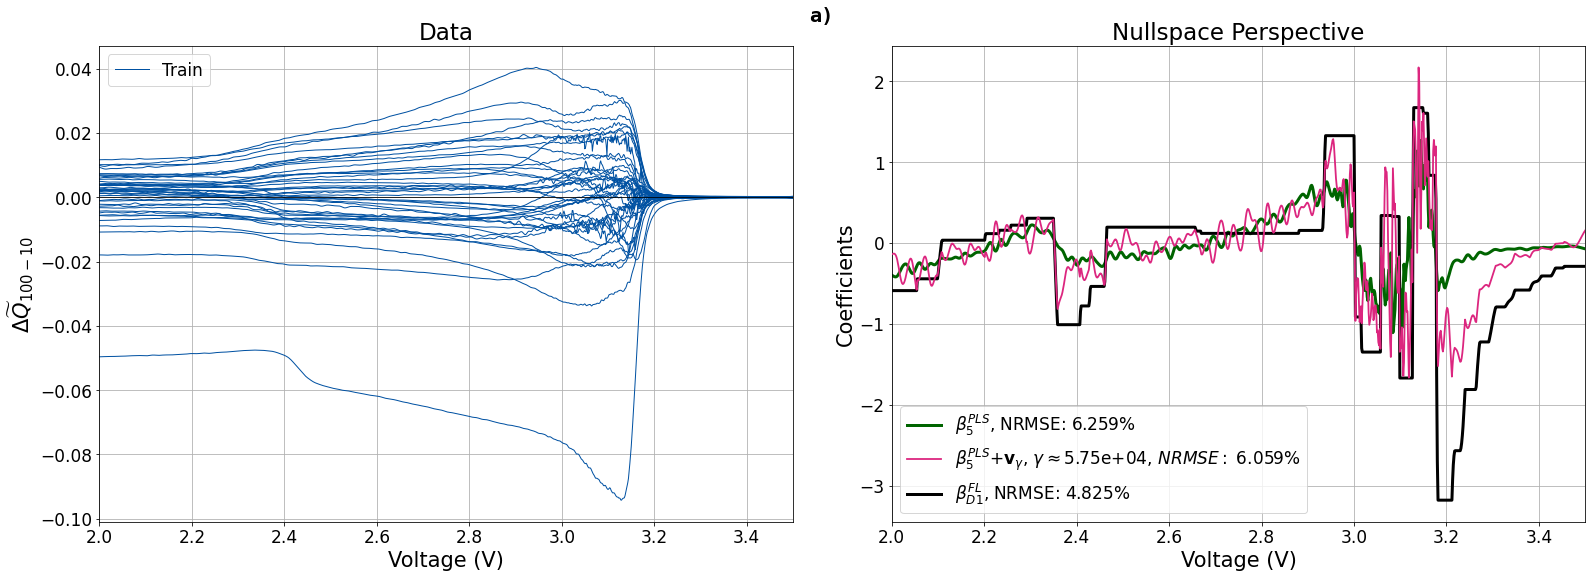

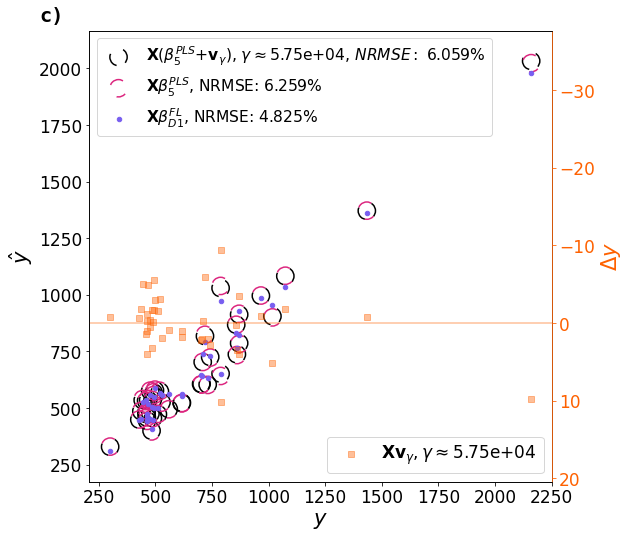

In [30]:
nulls_lfp_cl.set_standardization(std=False)
nulls_lfp_cl.set_nullspace_weights(
    key_alpha = 'PLS 5 Comp.', 
    w_alpha_name=r'$\beta_{5}^{PLS}$',
    w_beta = reg_coef_d1.iloc[:, 1],
    w_beta_name=r"$\beta_{D1}^{FL}$",
    )

nulls_lfp_cl, fig, ax = nulls_lfp_cl.nullspace_analysis(
    plot_results=True, 
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.2,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    )


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()

nulls_lfp_cl.scatter_predictions(y_transform=np.exp)

NRMSE constraint threshold:  0.23663115745552932
Constraint value: 0.236631257875, Method NRMSE


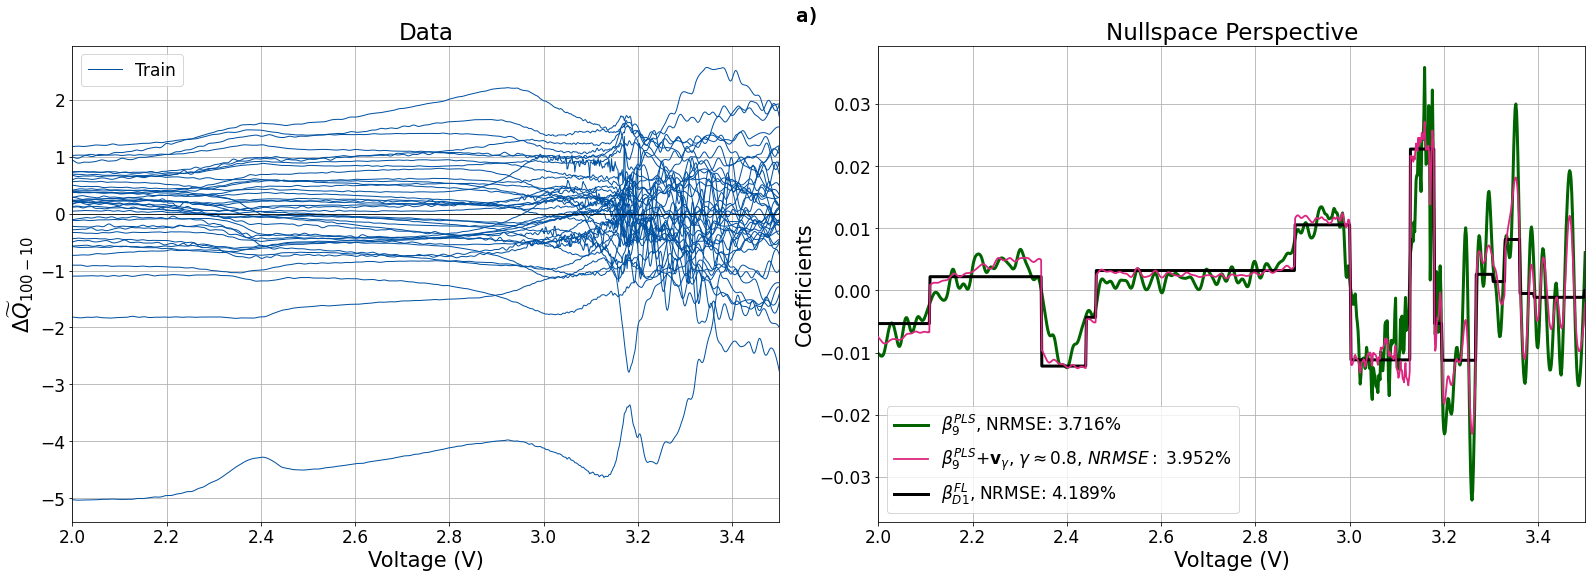

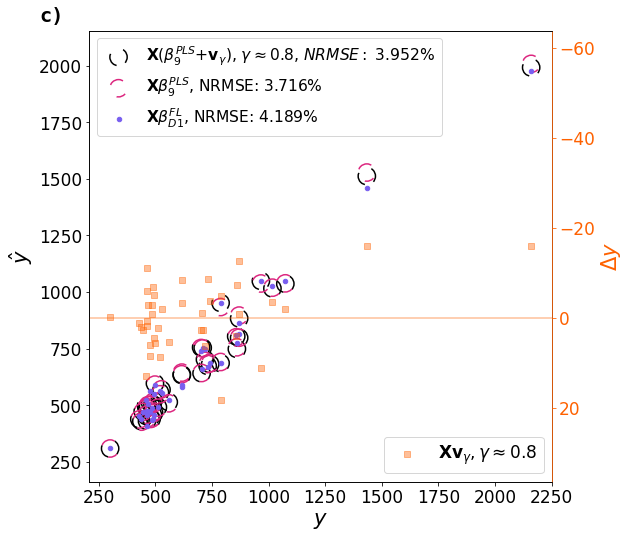

In [31]:
# 1.: The nullspace object always assumes that regression coefficeints are inserted 
# to X in the original scale. Therefore, we have to rescale the regression coefficients and set
# Std=True for the object to know that we want to perform the nullspace analysis on the standardized data.


nulls_lfp_cl.set_standardization(std=True)
nulls_lfp_cl.set_nullspace_weights(
    w_alpha = nulls_lfp_cl.weights['PLS 9 Comp. std']/np.std(X_, axis=0), 
    w_alpha_name=r'$\beta_{9}^{PLS}$',
    w_beta = reg_coef_d1_std.iloc[:, 1]/np.std(X_, axis=0),
    w_beta_name=r"$\beta_{D1}^{FL}$",
    )

nulls_lfp_cl, fig, ax = nulls_lfp_cl.nullspace_analysis(
    plot_results=True, 
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=-0.5,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    )

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()

nulls_lfp_cl.scatter_predictions(y_transform=np.exp)

# Nullspace Projection For the Cycle Life Response

In [32]:
NX = scipy.linalg.null_space(X_lfp_train) #, rcond=10**-5)
# Changing the rcond value is related to the singular values that are considered zero and 
# thus impact the dimensionality of the nullspace. 
NX_std = scipy.linalg.null_space(X_lfp_train_std)
print(f"Shape of the nullspace basis vector matrix: {NX.shape}")

Shape of the nullspace basis vector matrix: (1000, 959)


/var/folders/ht/42wc4pfd5y78cjfbdt_5qljr0000gn/T/ipykernel_60241/2602785120.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


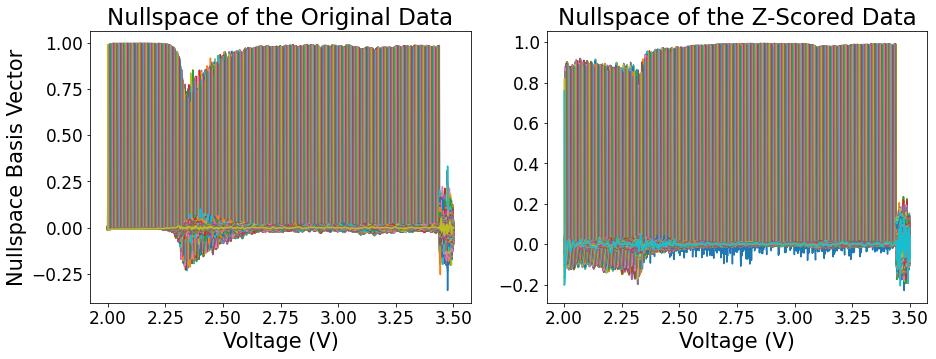

In [33]:
# Plot the individual basis vectors of the nullspae and see how the space changes after z-scoring
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.linspace(3.5, 2.0, 1000), NX)
ax[0].set_title('Nullspace of the Original Data')
ax[0].set_xlabel('Voltage (V)')
ax[0].set_ylabel('Nullspace Basis Vector')
ax[1].plot(np.linspace(3.5, 2.0, 1000), NX_std)
ax[1].set_title('Nullspace of the Z-Scored Data')
ax[1].set_xlabel('Voltage (V)')
fig.show()

# It's difficult to interpret when visualized this way. 
# Scipy constructs the nullspace basis vectors in a particular way such that they
# are orthogonal unit vectors which can be difficult to visualize (and interpret).

# Consider plotting the diagonal z-scoring matrix.

In [34]:
# Now project the reg_coeff onto the nullspace
# Lets write a function to do this
# This is also an example of the orthogonality of the column space to the nullsapce.
def project_reg_coeff_onto_nulls(reg_coeff, X):
    proj_matrix = (np.eye(X.shape[1])-X.T@scipy.linalg.inv(X@X.T)@X)
    proj_vector = proj_matrix@reg_coeff
    return proj_vector

def project_reg_coeff_onto_space_by_basis(reg_coeff, SX):
    proj_matrix = (SX@scipy.linalg.inv(SX.T@SX)@SX.T)
    proj_vector = proj_matrix@reg_coeff
    return proj_vector

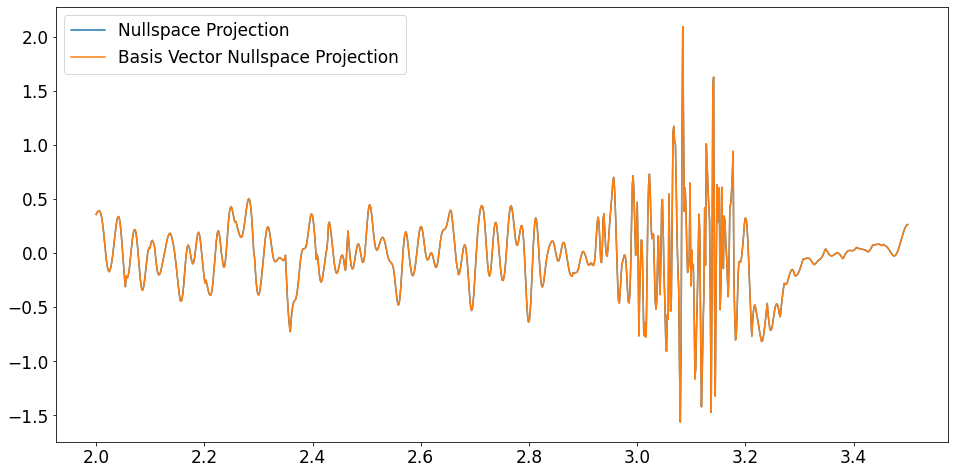

||NX.T@beta_orth|| 5.52e-11
||NX.T@beta_orth|| 1.26e-14


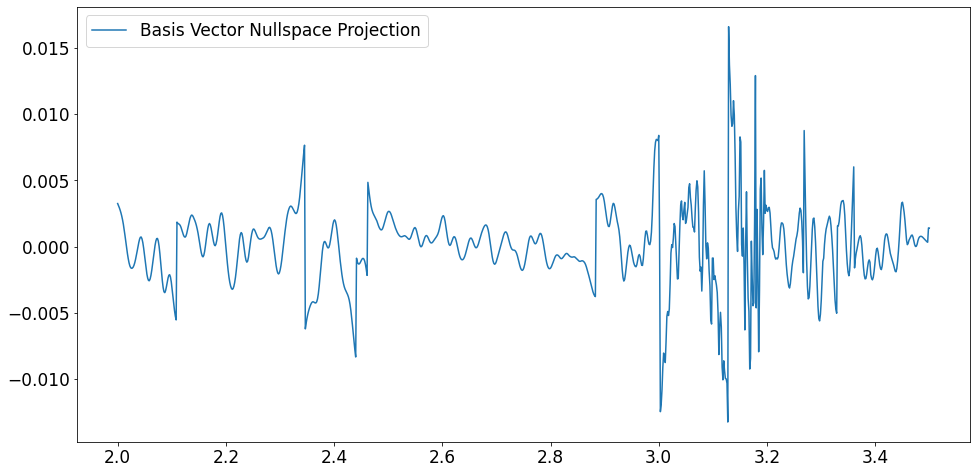

1.258467899744717e-16


In [35]:
beta_d1 = reg_coef_d1.iloc[:, 1]
x_lfp = np.linspace(2.0, 3.5, len(beta_d1))
beta_proj_nulls_ = project_reg_coeff_onto_nulls(beta_d1, X_lfp_train)
plt.plot(x_lfp, beta_proj_nulls_, label='Nullspace Projection')

beta_proj_nulls = project_reg_coeff_onto_space_by_basis(beta_d1, NX)
plt.plot(x_lfp, beta_proj_nulls, label="Basis Vector Nullspace Projection")
plt.legend()
plt.show() 
beta_orth = beta_d1-beta_proj_nulls_
print(f"||NX.T@beta_orth|| {np.linalg.norm(NX.T@beta_orth):.2e}")

beta_orth = beta_d1-beta_proj_nulls
print(f"||NX.T@beta_orth|| {np.linalg.norm(NX.T@beta_orth):.2e}")
# The scipy implementation is better

# Now lets do the same for coefficients learned from the z-scored data
beta_d1_std = reg_coef_d1_std.iloc[:, 1]
beta_proj_nulls_std = project_reg_coeff_onto_space_by_basis(beta_d1_std, NX_std)
plt.plot(x_lfp, beta_proj_nulls_std, label="Basis Vector Nullspace Projection")
plt.legend()
plt.show()
beta_orth_std = beta_d1_std-beta_proj_nulls_std
print(np.linalg.norm(NX_std.T@beta_orth_std))

In [36]:
print("Predition difference on  trainign data of beta_orth and beta_d1")
print(X_lfp_train@beta_orth - X_lfp_train@beta_d1)
# The predictiona are unchanged, as expected/designed

# Now std 
print("Predition difference z-scored trainign data of beta_orth and beta_d1")
print(X_lfp_train_std@beta_orth_std - X_lfp_train_std@beta_d1_std)

Predition difference on  trainign data of beta_orth and beta_d1
[-1.38777878e-16 -1.11022302e-16 -3.33066907e-16 -2.22044605e-16
  1.11022302e-16  0.00000000e+00 -4.44089210e-16 -4.44089210e-16
 -1.55431223e-15 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -8.88178420e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
  2.22044605e-16 -5.55111512e-16  0.00000000e+00 -4.44089210e-16
 -2.22044605e-15 -2.22044605e-16 -8.88178420e-16 -8.88178420e-16
  4.44089210e-16 -4.44089210e-16 -8.88178420e-16 -2.22044605e-16
  0.00000000e+00 -4.44089210e-16 -8.88178420e-16 -1.11022302e-15
 -8.88178420e-16 -4.44089210e-16  2.22044605e-16  4.44089210e-16
 -6.66133815e-16 -4.44089210e-16  2.22044605e-16 -6.66133815e-16
  0.00000000e+00]
Predition difference z-scored trainign data of beta_orth and beta_d1
[-2.22044605e-16 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  5.55111512e-17  1.11022302e-16 -3.33066907e-16 -2.77555756e-17
 -2.49800181e-16 -1.11022302e-16  0.00000000e+00  1.94289029e-16
  0.

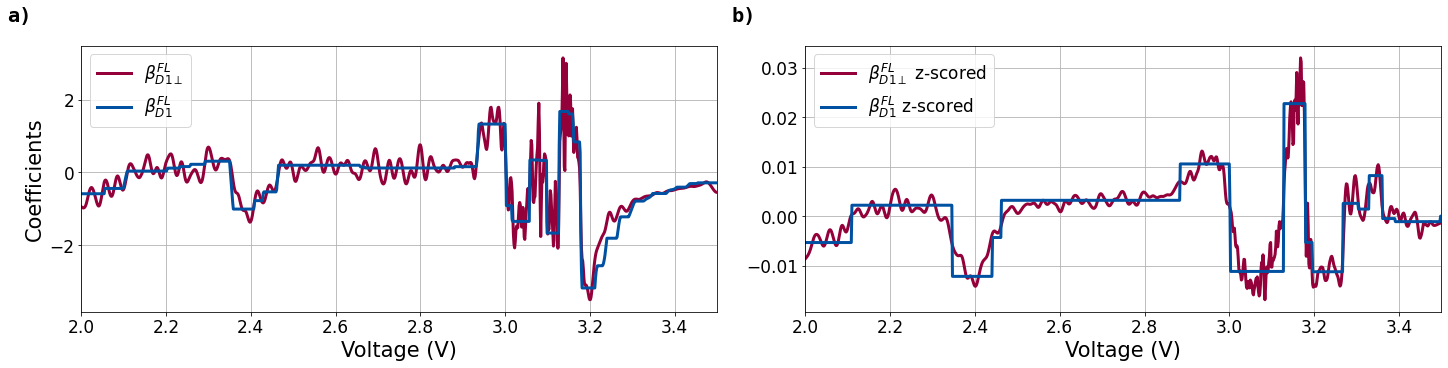

In [37]:
figsize = [20, 5]
fig, ax = plt.subplots(1, 2, figsize=figsize, constrained_layout=True, sharex=True, sharey=False)

fig, ax[0] = vis_reg_coef(
    beta = beta_orth,
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1\perp}^{FL}$",
    fig = fig, 
    ax = ax[0],
    cid=4)

fig, ax[0] = vis_reg_coef(
    beta = reg_coef_d1.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$",
    fig = fig, 
    ax = ax[0],
    cid=1)

fig, ax[1] = vis_reg_coef(
    beta = beta_orth_std,
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1\perp}^{FL}$ z-scored",
    fig = fig, 
    ax = ax[1],
    cid=4)

fig, ax[1] = vis_reg_coef(
    beta = reg_coef_d1_std.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$ z-scored",
    fig = fig, 
    ax = ax[1],
    cid=1)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.03, 1.0))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.03, 1.0))

ax[0].set_xlabel("Voltage (V)")
ax[1].set_xlabel("Voltage (V)")
ax[0].set_ylabel("Coefficients")

#fig.suptitle("Cross-Validate Generalized Lasso Regression Coefficients")

# Save figure
if save_plots:
    plt.savefig(save_plot_path + 'Fused_Lasso_Orthogonal_Nulls_Comp.pdf')

In [38]:
# Check the prediction accuracies of the projected vecotors.
df_rmse = predict_LFP_based_on_coef(
    X_, X_test1_, X_test2_, y_cl_train, y_cl_test, y_cl_test2, beta_orth, np.mean(y_log_cl), df_rmse, 'D1')

df_rmse = predict_LFP_based_on_coef(
    X_lfp_train_std, X_test1_std, X_test2_std, y_cl_train, y_cl_test, y_cl_test2, beta_orth_std, np.mean(y_log_cl), df_rmse, 'D1 Z-Scored')
# The prediction accuracies of the orthogonal regression coefficients are almost identical to the original regression coefficients.

RMSE Train:  67.77
RMSE Test 1:  113.91
RMSE Test 2:  197.44
RMSE Train:  61.63
RMSE Test 1:  107.1
RMSE Test 2:  192.59


In [39]:
# PLS Coefficients are orthogonal to the nullspace by construction
beta_pls_1_nulls_projected = project_reg_coeff_onto_space_by_basis(nulls_lfp_cl.weights['PLS 1 Comp.'], NX)
print(np.linalg.norm(beta_pls_1_nulls_projected))

beta_pls_9std_nulls_projected = project_reg_coeff_onto_space_by_basis(nulls_lfp_cl.weights['PLS 9 Comp. std'], NX_std)
print(np.linalg.norm(beta_pls_9std_nulls_projected))

8.706128256065803e-16
1.7474024448975115e-15


In [40]:
# Check the condition numbers of the parabolic data and the real data
temp_n = np.loadtxt(data_path + "poly_hd_data_n.csv", skiprows=1, delimiter=",") 
X_parab = temp_n[:,:-1]

cond_x_parab = np.linalg.cond(X_parab)
cond_xtx_parab = np.linalg.cond(X_parab.T@X_parab)
cond_xxT_parab  = np.linalg.cond(X_parab@X_parab.T)

cond_x_lfp = np.linalg.cond(X_lfp_train)
cond_xtx_lfp = np.linalg.cond(X_lfp_train.T@X_lfp_train)
cond_xxT_lfp  = np.linalg.cond(X_lfp_train@X_lfp_train.T)

print(f"Condition number of X_parab: {cond_x_parab:.2e}")
print(f"Condition number of X_parab.T@X_parab: {cond_xtx_parab:.2e}")
print(f"Condition number of X_parab@X_parab.T: {cond_xxT_parab:.2e}")
print(f"Condition number of X_lfp_train: {cond_x_lfp:.2e}")
print(f"Condition number of X_lfp_train.T@X_lfp_train: {cond_xtx_lfp:.2e}")
print(f"Condition number of X_lfp_train@X_lfp_train.T: {cond_xxT_lfp:.2e}")

Condition number of X_parab: 3.92e+05
Condition number of X_parab.T@X_parab: 5.33e+18
Condition number of X_parab@X_parab.T: 1.54e+11
Condition number of X_lfp_train: 3.31e+03
Condition number of X_lfp_train.T@X_lfp_train: 2.66e+24
Condition number of X_lfp_train@X_lfp_train.T: 1.09e+07
